# Prototype of model with just V1 Neurons

## Load data from GLIF Network directory

In [1]:
import numpy as np
import pandas as pd
from sonata.circuit import File
from pathlib import Path
import pickle
from pygenn.genn_model import GeNNModel, init_connectivity
from pygenn.genn_wrapper import NO_DELAY
import matplotlib.pyplot as plt

path_v1_nodes = Path(r"GLIF Network\network\v1_nodes.h5")
path_v1_nodes_types = Path(r"GLIF Network\network\v1_node_types.csv")
path_v1_edges = Path(r"GLIF Network\network\v1_v1_edges.h5")
path_v1_edges_types = Path(r"GLIF Network\network\v1_v1_edge_types.csv")

net = File(data_files=[path_v1_nodes, path_v1_edges], 
           data_type_files=[path_v1_nodes_types, path_v1_edges_types])

v1_nodes = net.nodes['v1']
v1_group = v1_nodes.get_group(v1_nodes.group_ids[0])  # Only 1 group in v1_nodes
v1_num_nodes = len(v1_group)

v1_edges = net.edges['v1_to_v1']
v1_num_edges = len(v1_edges)

## Extract pre_indices and post_indices from edges
### Save as pickle file to avoid having to go through the loop again

In [2]:
filename = 'v1_source_target_pairs.pickle'

if Path(filename).is_file():

    with open(filename, "rb") as f:
        source_target_pairs = pickle.load(f)
        
else:
    
    source_target_pairs = np.zeros((v1_num_edges, 2), dtype='int64')
    
    # TODO: Faster way to read edges besides looping?
    for i, edge in enumerate(v1_edges):
        
        if i % 10000 == 0:
            print("{i} of {v1_num_edges}".format(i=i, v1_num_edges=v1_num_edges))
            
        source = edge.source_node_id
        target = edge.target_node_id
        source_target_pairs[i] = [source, target]

    with open(filename, "wb") as f:
        pickle.dump(source_target_pairs, f) 
        
pre_indices, post_indices = source_target_pairs.T

## Construct model

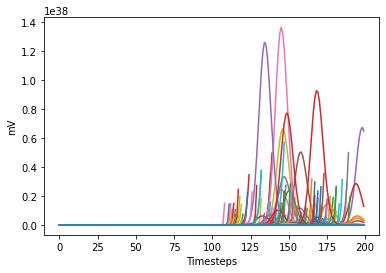

In [3]:
# Parameters copied from pygenn tutorial as a first pass
p = {"gNa": 7.15,   # Na conductance in [muS]
     "ENa": 50.0,   # Na equi potential [mV]
     "gK": 1.43,    # K conductance in [muS]
     "EK": -95.0,   # K equi potential [mV] 
     "gl": 0.02672, # leak conductance [muS]
     "El": -63.563, # El: leak equi potential in mV, 
     "C": 0.143}    # membr. capacity density in nF
ini = {"V": -60.0,      # membrane potential
       "m": 0.0529324,  # prob. for Na channel activation
       "h": 0.3176767,  # prob. for not Na channel blocking
       "n": 0.5961207}  # prob. for K channel activation
s_ini = {"g": -0.2}
ps_p = {"tau": 1.0, # Decay time constant [ms] 
        "E": -80.0} # Reversal potential [mV]

model = GeNNModel("float", "v1_only")
model.dT = 0.1

# Create v1 population
v1_pop = model.add_neuron_population("v1_pop", v1_num_nodes , "TraubMiles", p, ini)

# Create v1 to v1 synapse population
v1_pop_synapses = model.add_synapse_population(    pop_name = "v1_pop_synapses",
    matrix_type = "SPARSE_GLOBALG",
    delay_steps = 10,
    source = "v1_pop",
    target = "v1_pop",
    w_update_model = "StaticPulse",
    wu_param_space = {},
    wu_var_space = s_ini,
    wu_pre_var_space = {},
    wu_post_var_space = {},
    postsyn_model = "ExpCond",
    ps_param_space = ps_p,
    ps_var_space = {},
    connectivity_initialiser=None,
)

# Assign the synapse connections
v1_pop_synapses.set_sparse_connections(pre_indices, post_indices)

# Add initial stimulus to first neuron in v1_pop
initial_stimulus = {"startSpike": [0], "endSpike": [1]}
stim_pop = model.add_neuron_population("Stim", 1, "SpikeSourceArray", {}, initial_stimulus)
model.add_synapse_population("StimPop1", "SPARSE_GLOBALG", NO_DELAY,
    stim_pop, v1_pop,
    "StaticPulse", {}, s_ini, {}, {},
    "ExpCond", ps_p, {},
    init_connectivity("OneToOne", {}))
stim_pop.set_extra_global_param("spikeTimes", [0.0])

# Build the model
model.build()
model.load()

# Run a quick simulation
v = np.empty((2000, v1_num_nodes))
v_view = v1_pop.vars["V"].view
while model.t < 200.0:
    model.step_time()
    v1_pop.pull_var_from_device("V")
    
    v[model.timestep - 1,:]=v_view[:]
    
# Plot the results -- voltage of every 1000th neuron for 200 timesteps
fig, axis = plt.subplots()
axis.plot(v[:200,::1000])
axis.set_xlabel('Timesteps')
axis.set_ylabel('mV')
plt.show()

## Current prototype v1 model results in runaway/unrealistic excitation (voltages reaching 1e38 mV)

### Improvements to make to get better results: incorporating the values specific to each edge (syn_weight, weight_function, weight_sigma, delay) as well as the dynamics_params in the associated .json files
